
<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms as tfs
from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

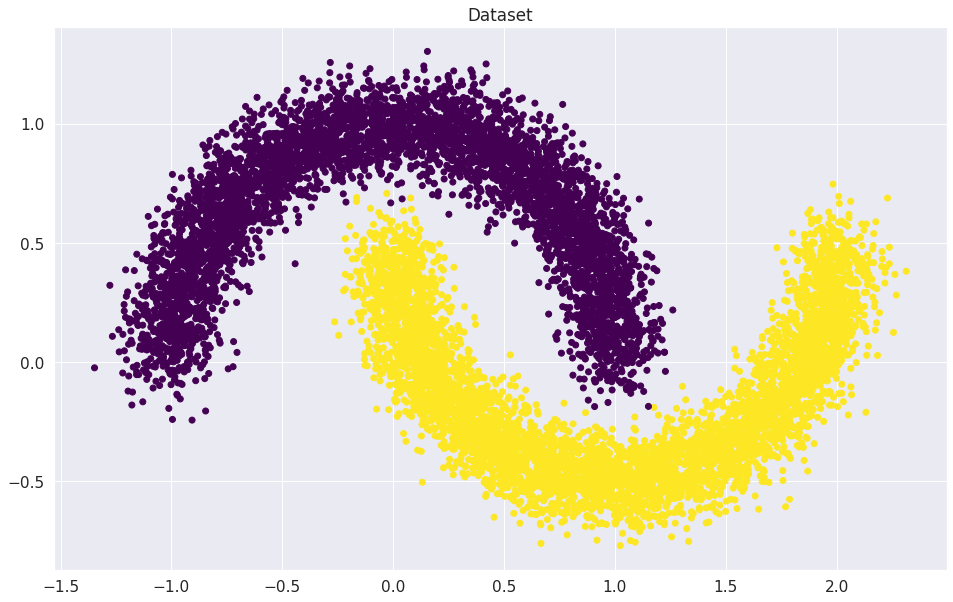

In [4]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [6]:
X_train_t =  torch.FloatTensor(X_train)
print(X_train_t.shape)
y_train_t =  torch.FloatTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.FloatTensor(y_val)

torch.Size([7500, 2])


Создаем `Dataset` и `DataLoader`. 

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128,
                              shuffle=True, num_workers = 2)
val_dataloader = DataLoader(val_dataset, batch_size=128,
                            shuffle=False, num_workers=2)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [17]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [18]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [19]:
from torchsummary import summary
print(list(linear_regression.parameters()))
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
linear_regression.to(device)
#summary(linear_regression, (2, ))

[Parameter containing:
tensor([[-0.7091],
        [ 1.1642]], requires_grad=True), Parameter containing:
tensor([0.0735], requires_grad=True)]
cuda:0


LinearRegression()

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [21]:
from tqdm.notebook import tqdm, trange

tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in trange(max_epochs):
    for it, (X_batch, y_batch) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch.to(device))
        loss =  loss_function(outp.view(outp.shape[0]), y_batch.to(device))
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  F.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch.to(device)).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 0
Batch accuracy: 0.2109375


  0%|          | 0/59 [00:00<?, ?it/s]

Iteration: 100
Batch accuracy: 0.75


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Iteration: 200
Batch accuracy: 0.75


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Iteration: 300
Batch accuracy: 0.7734375


  0%|          | 0/59 [00:00<?, ?it/s]

Iteration: 400
Batch accuracy: 0.828125


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Iteration: 500
Batch accuracy: 0.8515625


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Iteration: 600
Batch accuracy: 0.8515625


  0%|          | 0/59 [00:00<?, ?it/s]

Iteration: 700
Batch accuracy: 0.828125


  0%|          | 0/59 [00:00<?, ?it/s]


Iteration: 759.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** В данной ситуации потребовалось 759 итераций

### Визуализируем результаты

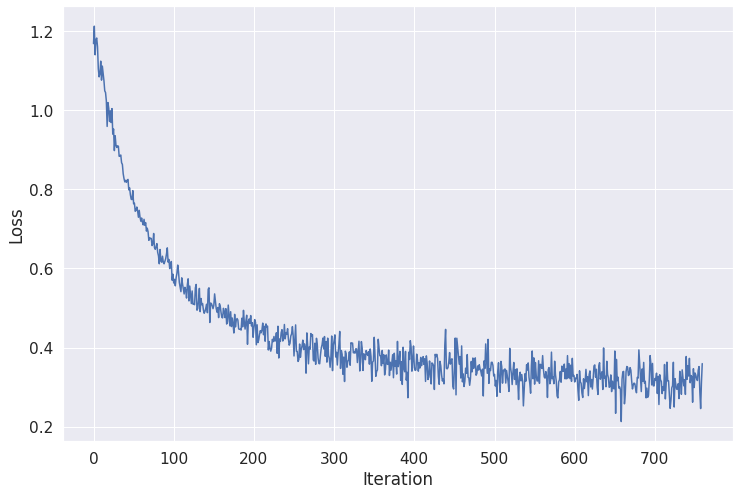

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

[[-1.5  -1.5  -1.5  ... -1.5  -1.5  -1.5 ]
 [-1.49 -1.49 -1.49 ... -1.49 -1.49 -1.49]
 [-1.48 -1.48 -1.48 ... -1.48 -1.48 -1.48]
 ...
 [ 2.47  2.47  2.47 ...  2.47  2.47  2.47]
 [ 2.48  2.48  2.48 ...  2.48  2.48  2.48]
 [ 2.49  2.49  2.49 ...  2.49  2.49  2.49]]
[-1.5  -1.5  -1.5  ...  2.49  2.49  2.49]
[[-1.5  -1.  ]
 [-1.5  -0.99]
 [-1.5  -0.98]
 ...
 [ 2.49  1.47]
 [ 2.49  1.48]
 [ 2.49  1.49]]


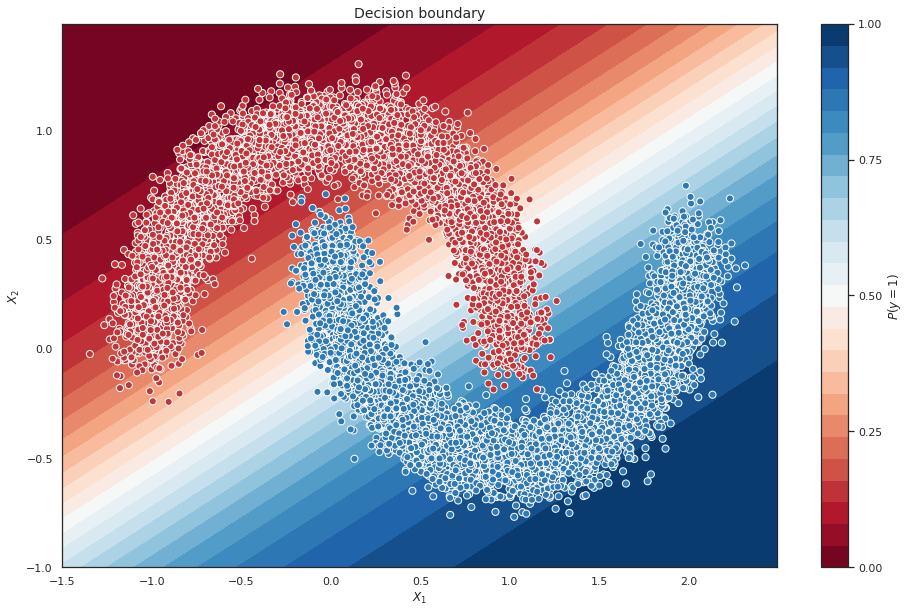

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
print(xx)
grid = np.c_[xx.ravel(), yy.ravel()]
print(xx.ravel())
print(grid)
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [25]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        x_batch = x_batch.to(device)
        outp = model(x_batch)
        preds = (F.sigmoid(outp) > 0.5)
        predictions = np.hstack((predictions, preds.cpu().numpy().flatten()))
    return predictions.flatten()

In [26]:
from sklearn.metrics import accuracy_score

predictions = predict(val_dataloader, linear_regression)
acc = accuracy_score(y_val, predictions)
print(f"Test accuracy: {acc}")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test accuracy: 0.8564


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** Значение метрики Accuracy на тестовой выборке равно 0.86

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [27]:
import os
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True,
                               num_workers=2)
valid_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False,
                              num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [28]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [29]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ELU(),
    nn.Linear(128, 10)
)
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=10, bias=True)
)

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [31]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in trange(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in tqdm(dataloader):
            if k == "train":
              model.train()
              x_batch = x_batch.to(device)
              y_batch = y_batch.to(device)
              outp = model(x_batch)
              loss = criterion(outp, y_batch)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
            else:
              model.eval()
              with torch.no_grad():
                outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).sum()
            all =  y_batch.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.89315


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9395


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.9474666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9625


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9629166666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.967


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9715166666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9705


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9750833333333333


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9693


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9777666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9757


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9804333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.969


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9819333333333333


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9753


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.98455


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9759


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9857333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9755


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [32]:
elu_accuracy = accuracy["valid"]

In [35]:

def test_activation_function(activation):
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 10)
    )
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    max_epochs = 10

    accuracy = {"train": [], "valid": []}
    for epoch in trange(max_epochs):
      for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in tqdm(dataloader):
          if k == "train":
            model.train()
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            outp = model(x_batch)
            loss = criterion(outp, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          else:
            model.eval()
            with torch.no_grad():
              outp = model(x_batch.to(device))
          preds = outp.argmax(-1)
          correct =  (preds == y_batch.to(device)).sum()
          all =  y_batch.shape[0]
          epoch_correct += correct.item()
          epoch_all += all
        if k == "train":
          print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]

In [36]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8784333333333333


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9053


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.9035166666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9096


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9083666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9174


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9097166666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9061


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9112333333333333


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.915


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9132333333333333


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9142


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9129333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9147


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9154666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9159


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9159


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9192


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9156666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9153


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8898


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9352


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.94395


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9566


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9579166666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9635


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9655833333333333


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9661


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9695333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9658


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9737666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9669


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9756333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9693


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9779833333333333


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9646


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9802666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9681


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9817


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9698


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8905666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9281


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.94215


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9572


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9593666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.956


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9654166666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9667


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9708


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.971


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9741666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9658


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9764166666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9682


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9778333333333333


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9716


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9799833333333333


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9733


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9832


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9712


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

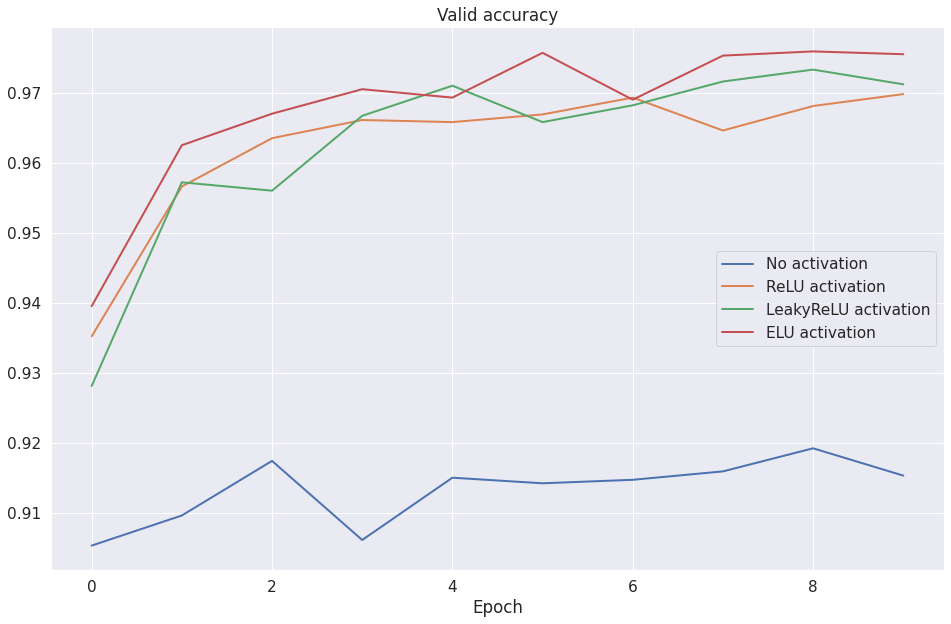

In [37]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

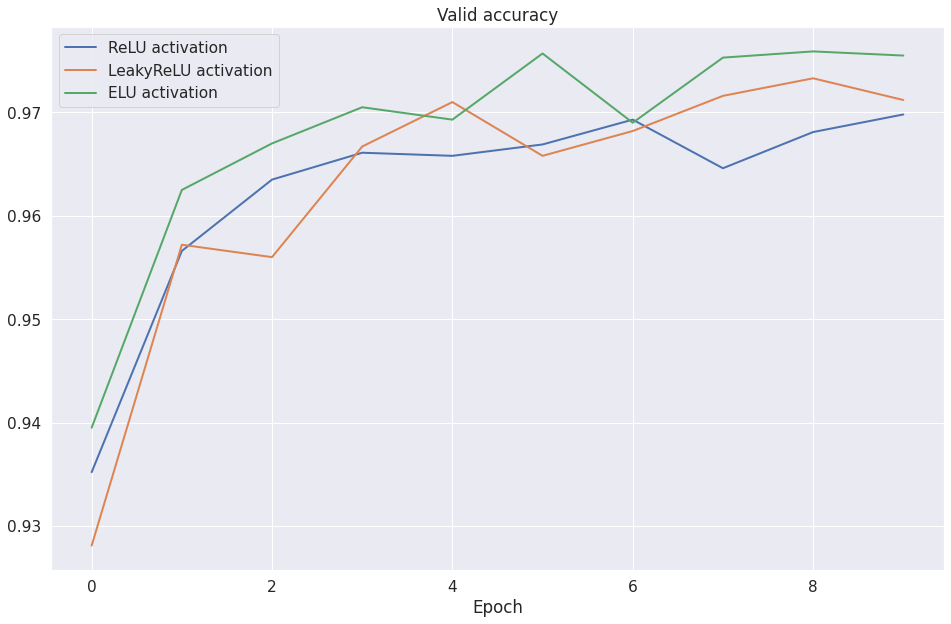

In [38]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [39]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-01-30 16:07:41--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-01-30 16:07:41--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.02s   

2022-01-30 16:07:41 (1.88 MB/s) - ‘sample_photo.jpg’ saved [49337/

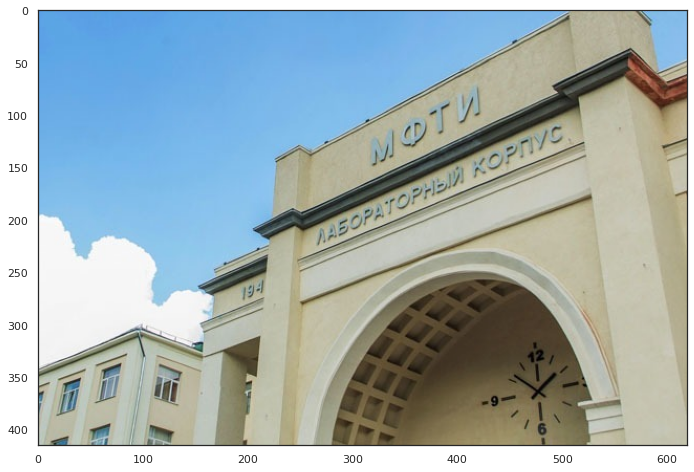

In [40]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [50]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

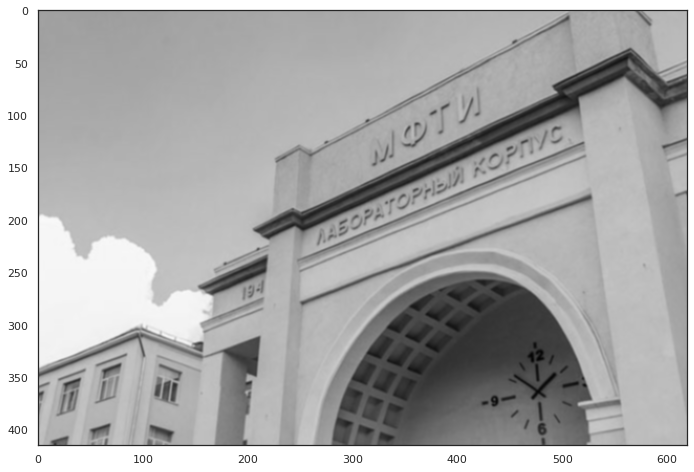

In [51]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** A-3, Б-5, В-4, Г-6, Д-2, Е-1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [57]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [58]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [59]:
epochs = 10
running_loss_train = 0
running_loss_valid = 0

running_loss = {"train" : 0, "valid" : 0}
losses = {"train" : [], "valid" : []}
accuracy = {"train": [], "valid": []}

for epoch in trange(epochs):
  print(f"Epoch {epoch + 1}")
  for k, loader in loaders.items():
    epoch_correct = 0
    epoch_all = 0
    for i, (x_batch, y_batch) in enumerate(tqdm(loader)):
      if k=="train":
        model.train()
        output = model(x_batch.to(device))
        loss = criterion(output, y_batch.to(device))
        running_loss["train"] += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      else:
        model.eval()
        with torch.no_grad():
          output = model(x_batch.to(device))
          loss = criterion(output, y_batch.to(device))
          running_loss["valid"] += loss.item()
        
      predictions = output.argmax(-1)
      epoch_correct += (predictions == y_batch.to(device)).sum().item()
      epoch_all += y_batch.shape[0]
    print(f"Loader: {k}, accuracy: {epoch_correct / epoch_all}")
    accuracy[k].append(epoch_correct / epoch_all)
    losses[k].append(running_loss[k])
    running_loss[k] = 0

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

Loader: train, accuracy: 0.9143166666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid, accuracy: 0.9737
Epoch 2


  0%|          | 0/938 [00:00<?, ?it/s]

Loader: train, accuracy: 0.9775333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid, accuracy: 0.9838
Epoch 3


  0%|          | 0/938 [00:00<?, ?it/s]

Loader: train, accuracy: 0.9837833333333333


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid, accuracy: 0.9867
Epoch 4


  0%|          | 0/938 [00:00<?, ?it/s]

Loader: train, accuracy: 0.98695


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid, accuracy: 0.9878
Epoch 5


  0%|          | 0/938 [00:00<?, ?it/s]

Loader: train, accuracy: 0.9894


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid, accuracy: 0.9905
Epoch 6


  0%|          | 0/938 [00:00<?, ?it/s]

Loader: train, accuracy: 0.9907666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid, accuracy: 0.9832
Epoch 7


  0%|          | 0/938 [00:00<?, ?it/s]

Loader: train, accuracy: 0.9922333333333333


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid, accuracy: 0.9889
Epoch 8


  0%|          | 0/938 [00:00<?, ?it/s]

Loader: train, accuracy: 0.99375


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid, accuracy: 0.9853
Epoch 9


  0%|          | 0/938 [00:00<?, ?it/s]

Loader: train, accuracy: 0.99375


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid, accuracy: 0.9897
Epoch 10


  0%|          | 0/938 [00:00<?, ?it/s]

Loader: train, accuracy: 0.9949666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Loader: valid, accuracy: 0.9907


In [60]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

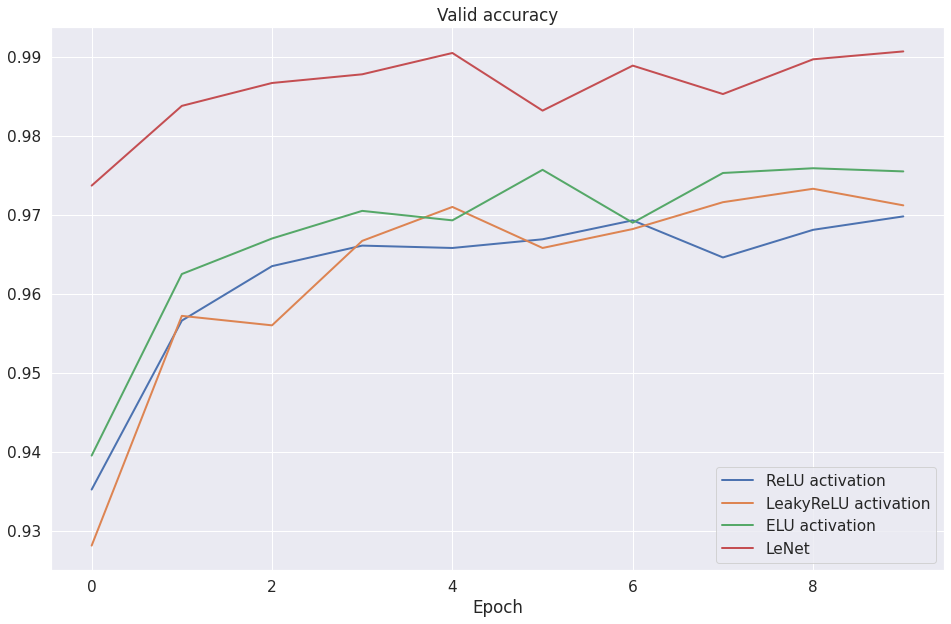

In [62]:
sns.set(style="darkgrid", font_scale=1.4)
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

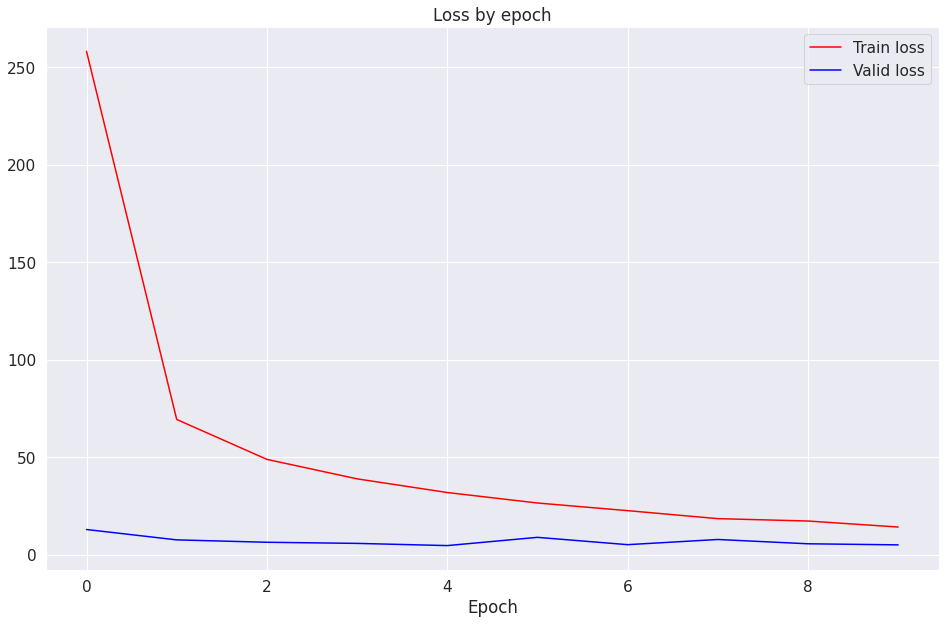

In [63]:
plt.figure(figsize=(16, 10))
plt.title("Loss by epoch")
plt.plot(losses["train"], label="Train loss", color="red")
plt.plot(losses["valid"], label="Valid loss", color="blue")
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99